In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00


In [2]:
import os
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import cv2
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix
import torch
from torch_geometric.data import Data
from scipy.spatial import Delaunay
from skimage.transform import resize
from torch_geometric.loader import DataLoader
from torch.nn import Linear, ReLU
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
import networkx as nx
import requests
from PIL import Image
import io
from skimage.segmentation import slic
from skimage.measure import regionprops
import kagglehub
from pathlib import Path
import shutil

2025-05-08 15:30:39.936571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746718240.116816      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746718240.168257      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Sử dụng: {device}")

🔧 Sử dụng: cuda


In [4]:
# target_dir = Path("data/intel-image-classification")

In [5]:
# if target_dir.exists():
#     print("✅ Dữ liệu đã tồn tại tại:", target_dir)
# else:
#     print("⬇️ Đang tải dữ liệu từ Kaggle...")
#     # Tải về thư mục mặc định của kagglehub (~/.cache/kagglehub/...)
#     downloaded_path = kagglehub.dataset_download("puneet6060/intel-image-classification")

#     # Di chuyển toàn bộ nội dung vào thư mục 'data/intel-image-classification'
#     shutil.copytree(downloaded_path, target_dir)
#     print("✅ Dữ liệu đã được lưu tại:", target_dir)

In [6]:
## ========================= Run on local =========================
# train_path = './data/intel-image-classification/seg_train/'
# test_path = './data/intel-image-classification/seg_test/'
# pred_path = './data/intel-image-classification/seg_pred/'

## ========================= Run on Kaggle =========================

train_path = '/kaggle/input/intel-image-classification/seg_train/'
test_path = '/kaggle/input/intel-image-classification/seg_test/'
pred_path = '/kaggle/input/intel-image-classification/seg_pred/'


In [7]:
def open_folders(path, file, name = 'Traning Data'):
    for folder in os.listdir(path + file):
        files = gb.glob(pathname = path + file + '/' + folder + '/*.jpg')
        print(f'{name} : Tìm thấy {len(files)} ảnh trong thư mục {folder}')

print('-' * 40 + ' Traning Data ' + '-' * 46)
open_folders(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
open_folders(test_path, 'seg_test', name = 'Test Data')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
files = gb.glob(pathname = pred_path + 'seg_pred' + '/*.jpg')
print(f'Prediction Data : Tìm thấy {len(files)} ảnh trong thư mục Prediction')

---------------------------------------- Traning Data ----------------------------------------------
Traning Data : Tìm thấy 2512 ảnh trong thư mục mountain
Traning Data : Tìm thấy 2382 ảnh trong thư mục street
Traning Data : Tìm thấy 2191 ảnh trong thư mục buildings
Traning Data : Tìm thấy 2274 ảnh trong thư mục sea
Traning Data : Tìm thấy 2271 ảnh trong thư mục forest
Traning Data : Tìm thấy 2404 ảnh trong thư mục glacier

---------------------------------------- Test Data --------------------------------------------------
Test Data : Tìm thấy 525 ảnh trong thư mục mountain
Test Data : Tìm thấy 501 ảnh trong thư mục street
Test Data : Tìm thấy 437 ảnh trong thư mục buildings
Test Data : Tìm thấy 510 ảnh trong thư mục sea
Test Data : Tìm thấy 474 ảnh trong thư mục forest
Test Data : Tìm thấy 553 ảnh trong thư mục glacier

---------------------------------------- Prediction Data --------------------------------------------
Prediction Data : Tìm thấy 7301 ảnh trong thư mục Prediction


In [8]:
def get_image_size(path, folder_name):
    size = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname = path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = plt.imread(file)
                size.append(image.shape)
    else:
        files = gb.glob(pathname = path + folder_name + '/*.jpg')
        for file in files:
            image = plt.imread(file)
            size.append(image.shape)

    print(pd.Series(size).value_counts())

print('-' * 40 + ' Traning Data ' + '-' * 46)
get_image_size(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
get_image_size(test_path, 'seg_test')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
get_image_size(pred_path, 'seg_pred')


---------------------------------------- Traning Data ----------------------------------------------
(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(144, 150, 3)        2
(143, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(108, 150, 3)        2
(136, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(100, 150, 3)        1
(141, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(147, 150, 3)        1
(131, 150, 3)        1
(81, 150, 3)         1
(140, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(149, 150, 3)        1
(110, 150, 3)        1
(105, 150, 3)        1
(97, 150, 3)         1
(120, 150, 3)        1
(76, 150, 3)         1
(119, 150, 3)        1
(102, 150, 3)        1
Name: count, dtype: int64

---------------------------------------- Test Data --------------------------------------------------
(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)

In [9]:
# Get Image In Arrays And Resize Images
# Ánh xạ tên lớp thành số nguyên
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

# Chuyển số (label) → Tên lớp (chuỗi)
def get_name(code_number):
    for key, value in code.items():
        if code_number == value:
            return key

In [10]:
# Đọc toàn bộ ảnh .jpg trong một thư mục chứa các lớp (như seg_train hoặc seg_test)

# Resize ảnh về cùng kích thước (100×100 pixels)

# Chuyển ảnh thành mảng số (array)

# Nếu có nhãn (tên lớp), ánh xạ thành số theo từ điển code

# Trả về:

# X: danh sách các ảnh (dạng array)

# y: danh sách nhãn tương ứng (nếu có)

new_size = 100
def get_image_array(path, folder_name, new_size = new_size):
    X = []
    y = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname= path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = cv2.imread(file)
                image_array = cv2.resize(image, (new_size, new_size))
                X.append(list(image_array))
                y.append(code[folder])
    else :
        files = gb.glob(pathname= path + folder_name + '/*.jpg')
        for file in files:
            image = cv2.imread(file)
            image_array = cv2.resize(image, (new_size, new_size))
            X.append(list(image_array))
    return X, y

In [11]:
X_train, y_train = get_image_array(train_path, 'seg_train')
X_test, y_test = get_image_array(test_path, 'seg_test')
X_pred, y_pred = get_image_array(pred_path, 'seg_pred')

print('-' * 40 + ' Traning Data ' + '-' * 46)
print(f'Có {len(X_train)} files X_train')
print(f'Có {len(y_train)} files y_train ')

print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
print(f'Có {len(X_test)} files X_test')
print(f'Có {len(y_test)} files y_test')

print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
print(f'Có {len(X_pred)} files X_pred')
print(f'Có {len(y_pred)} files y_pred')
def plot_some_image(X, y, name):
    print('-' * 77 + f' {name} Data ' + '-' * 77)
    plt.figure(figsize = (20, 32))
    for n, i in enumerate(list(np.random.randint(0, len(X), 16))):
        plt.subplot(4, 4, n+1)
        plt.imshow(X[i])
        plt.axis('off')
        if name != 'Prediction':
            plt.title(get_name(y[i]), fontdict = {'fontsize': 18, 'color': 'blue'})


---------------------------------------- Traning Data ----------------------------------------------
Có 14034 files X_train
Có 14034 files y_train 

---------------------------------------- Test Data --------------------------------------------------
Có 3000 files X_test
Có 3000 files y_test

---------------------------------------- Test Data --------------------------------------------------
Có 7301 files X_pred
Có 0 files y_pred


----------------------------------------------------------------------------- Traning Data -----------------------------------------------------------------------------


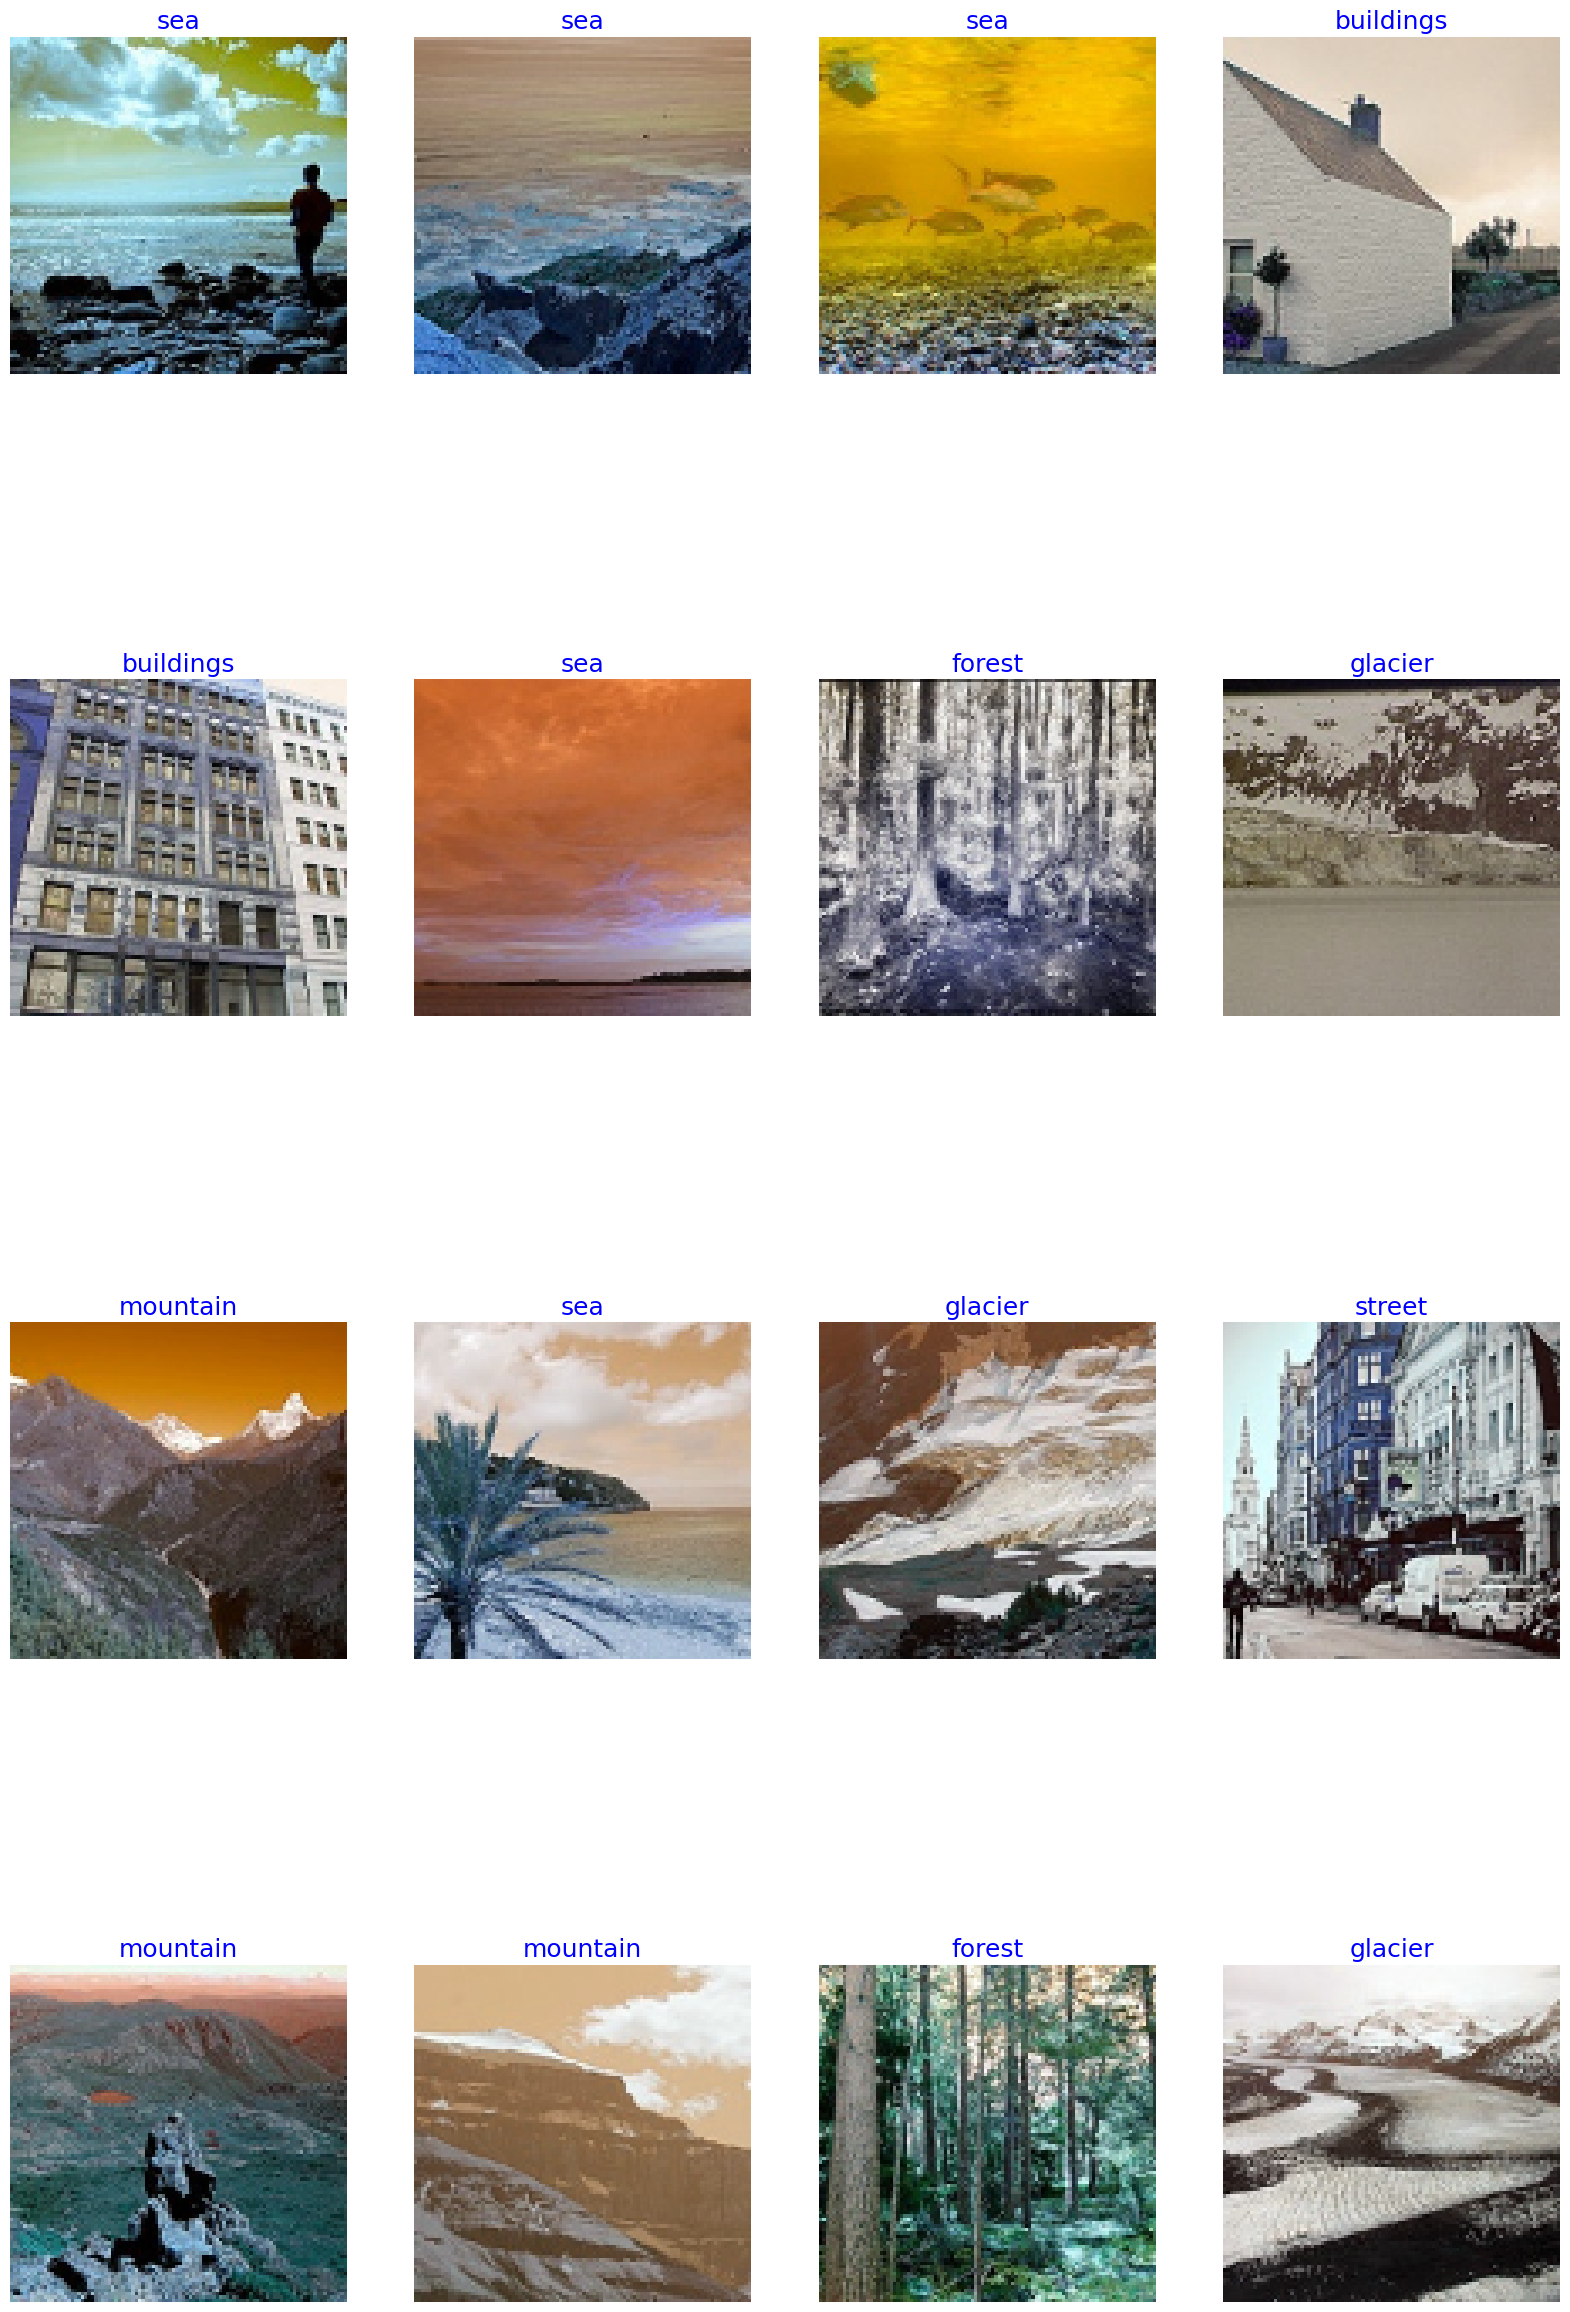

In [12]:
plot_some_image(X_train, y_train, name = 'Traning')

----------------------------------------------------------------------------- Test Data -----------------------------------------------------------------------------


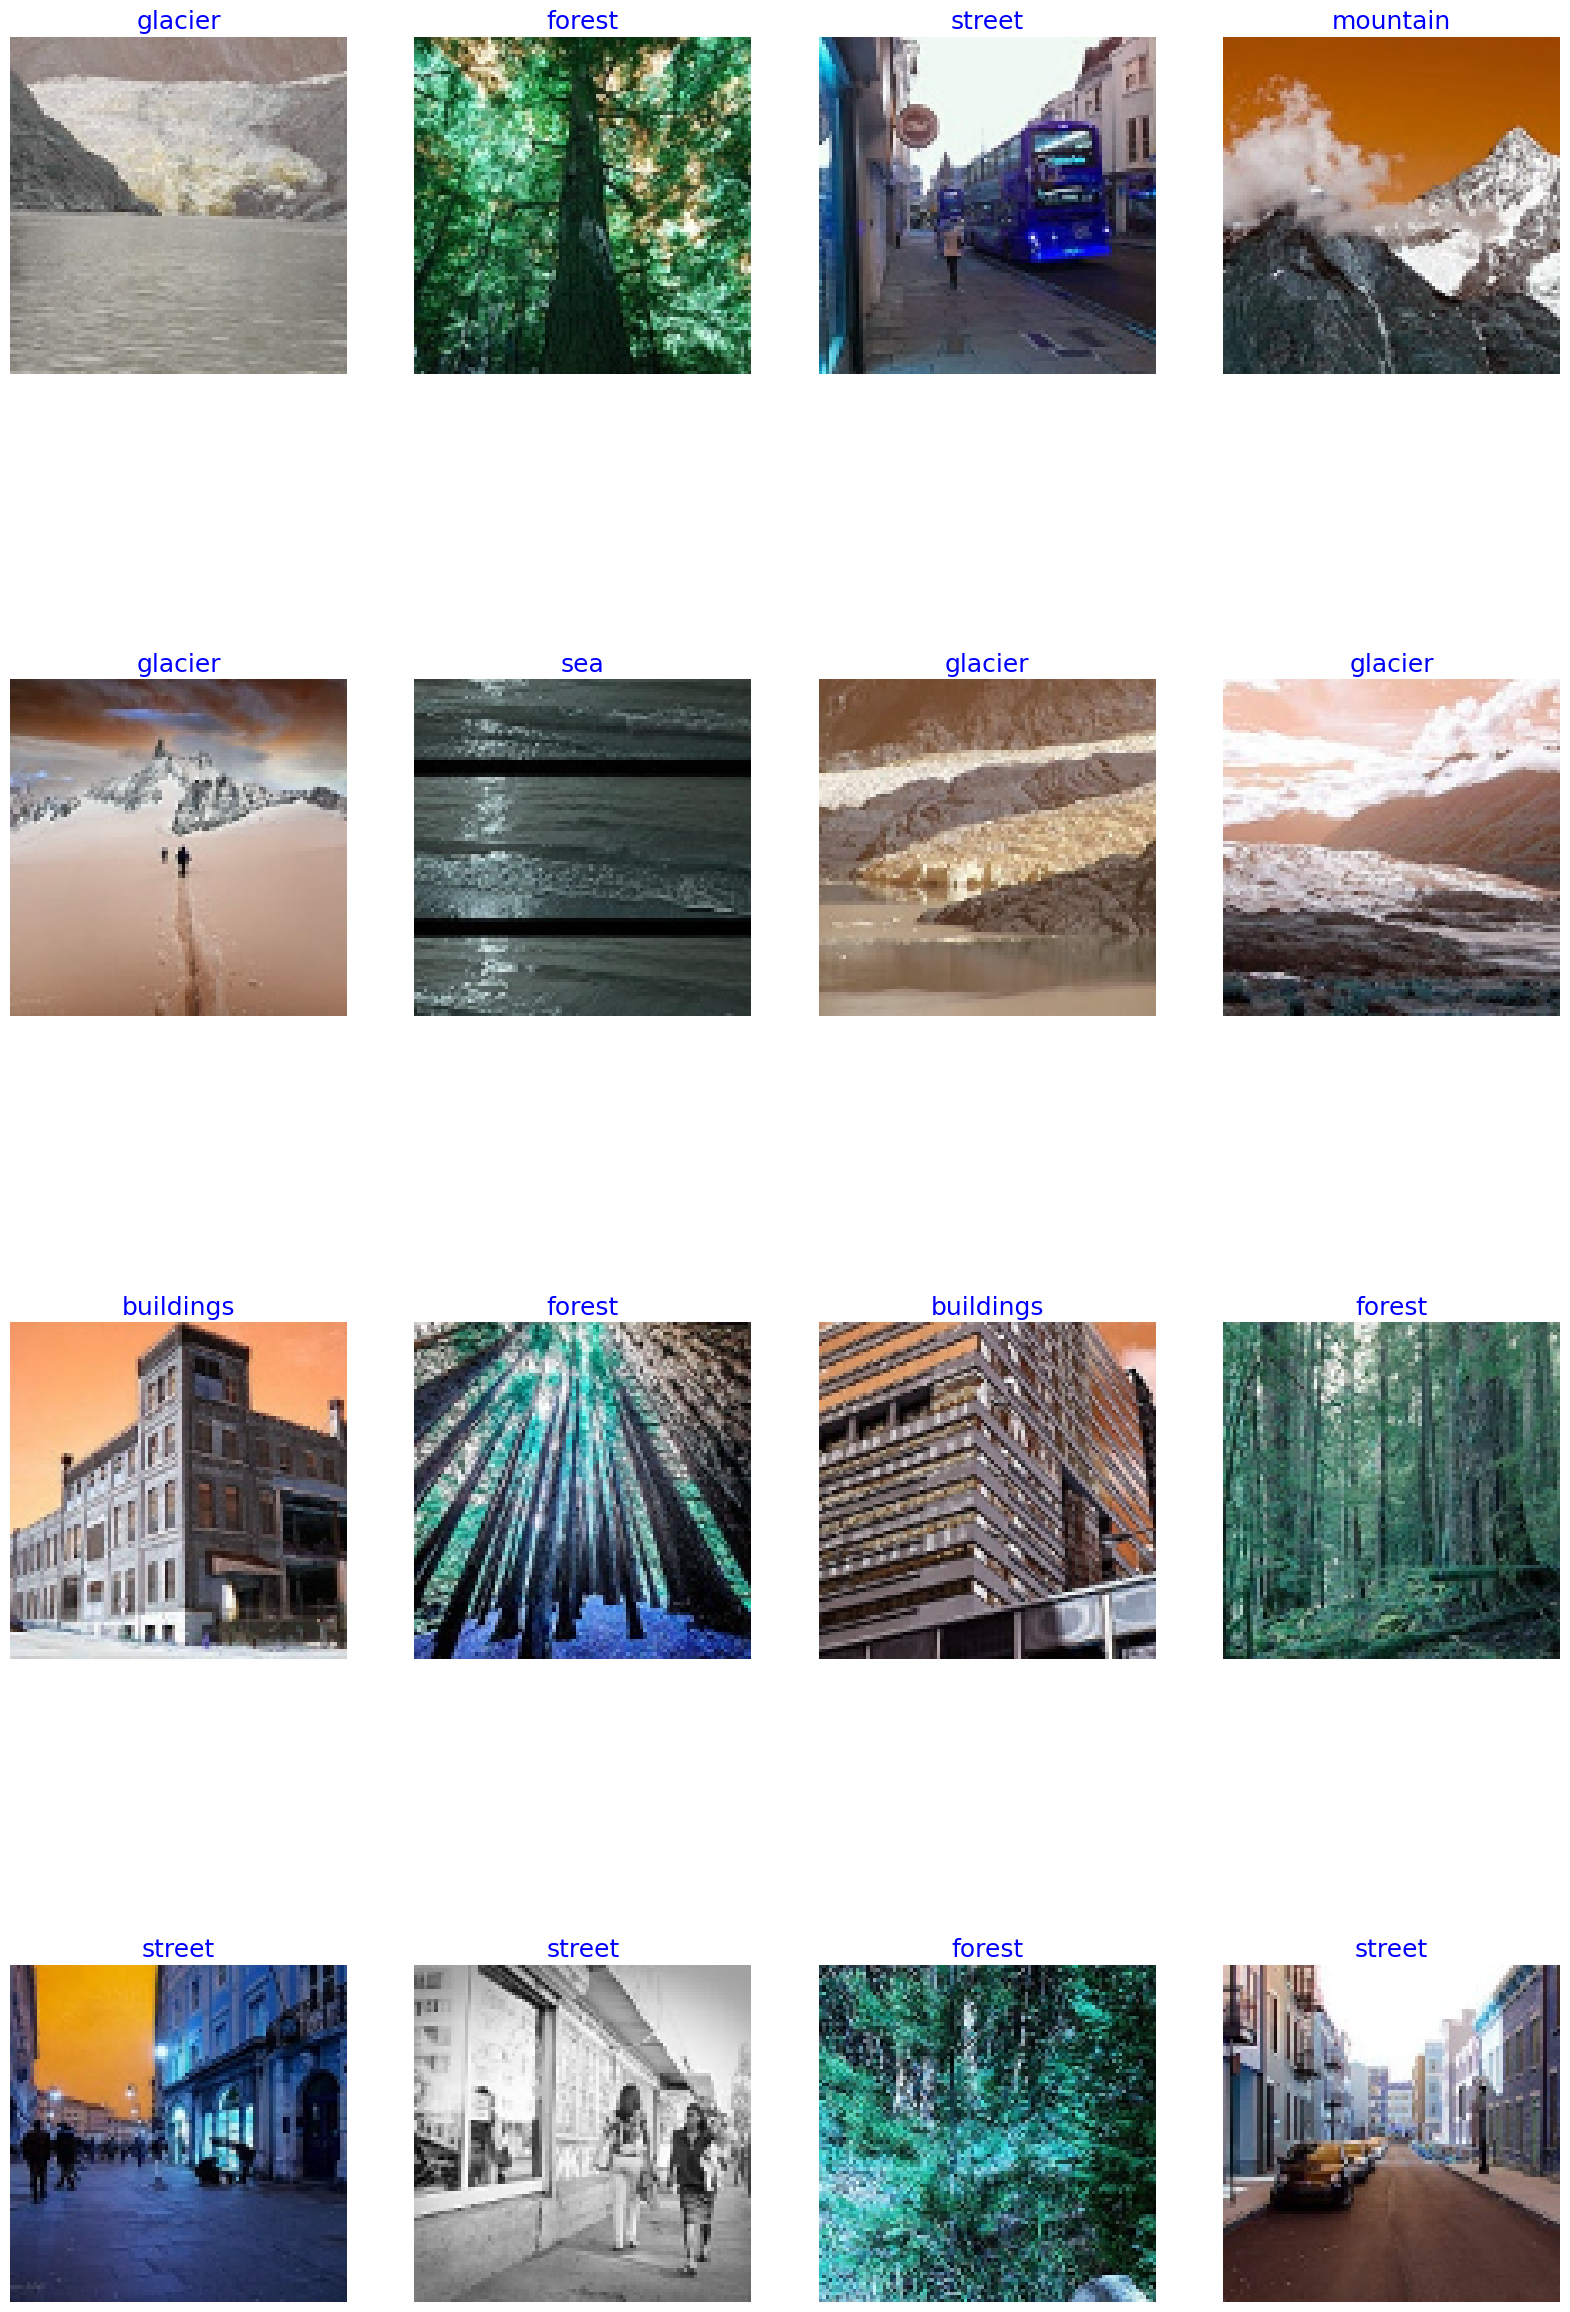

In [13]:
plot_some_image(X_test, y_test, 'Test')

----------------------------------------------------------------------------- Prediction Data -----------------------------------------------------------------------------


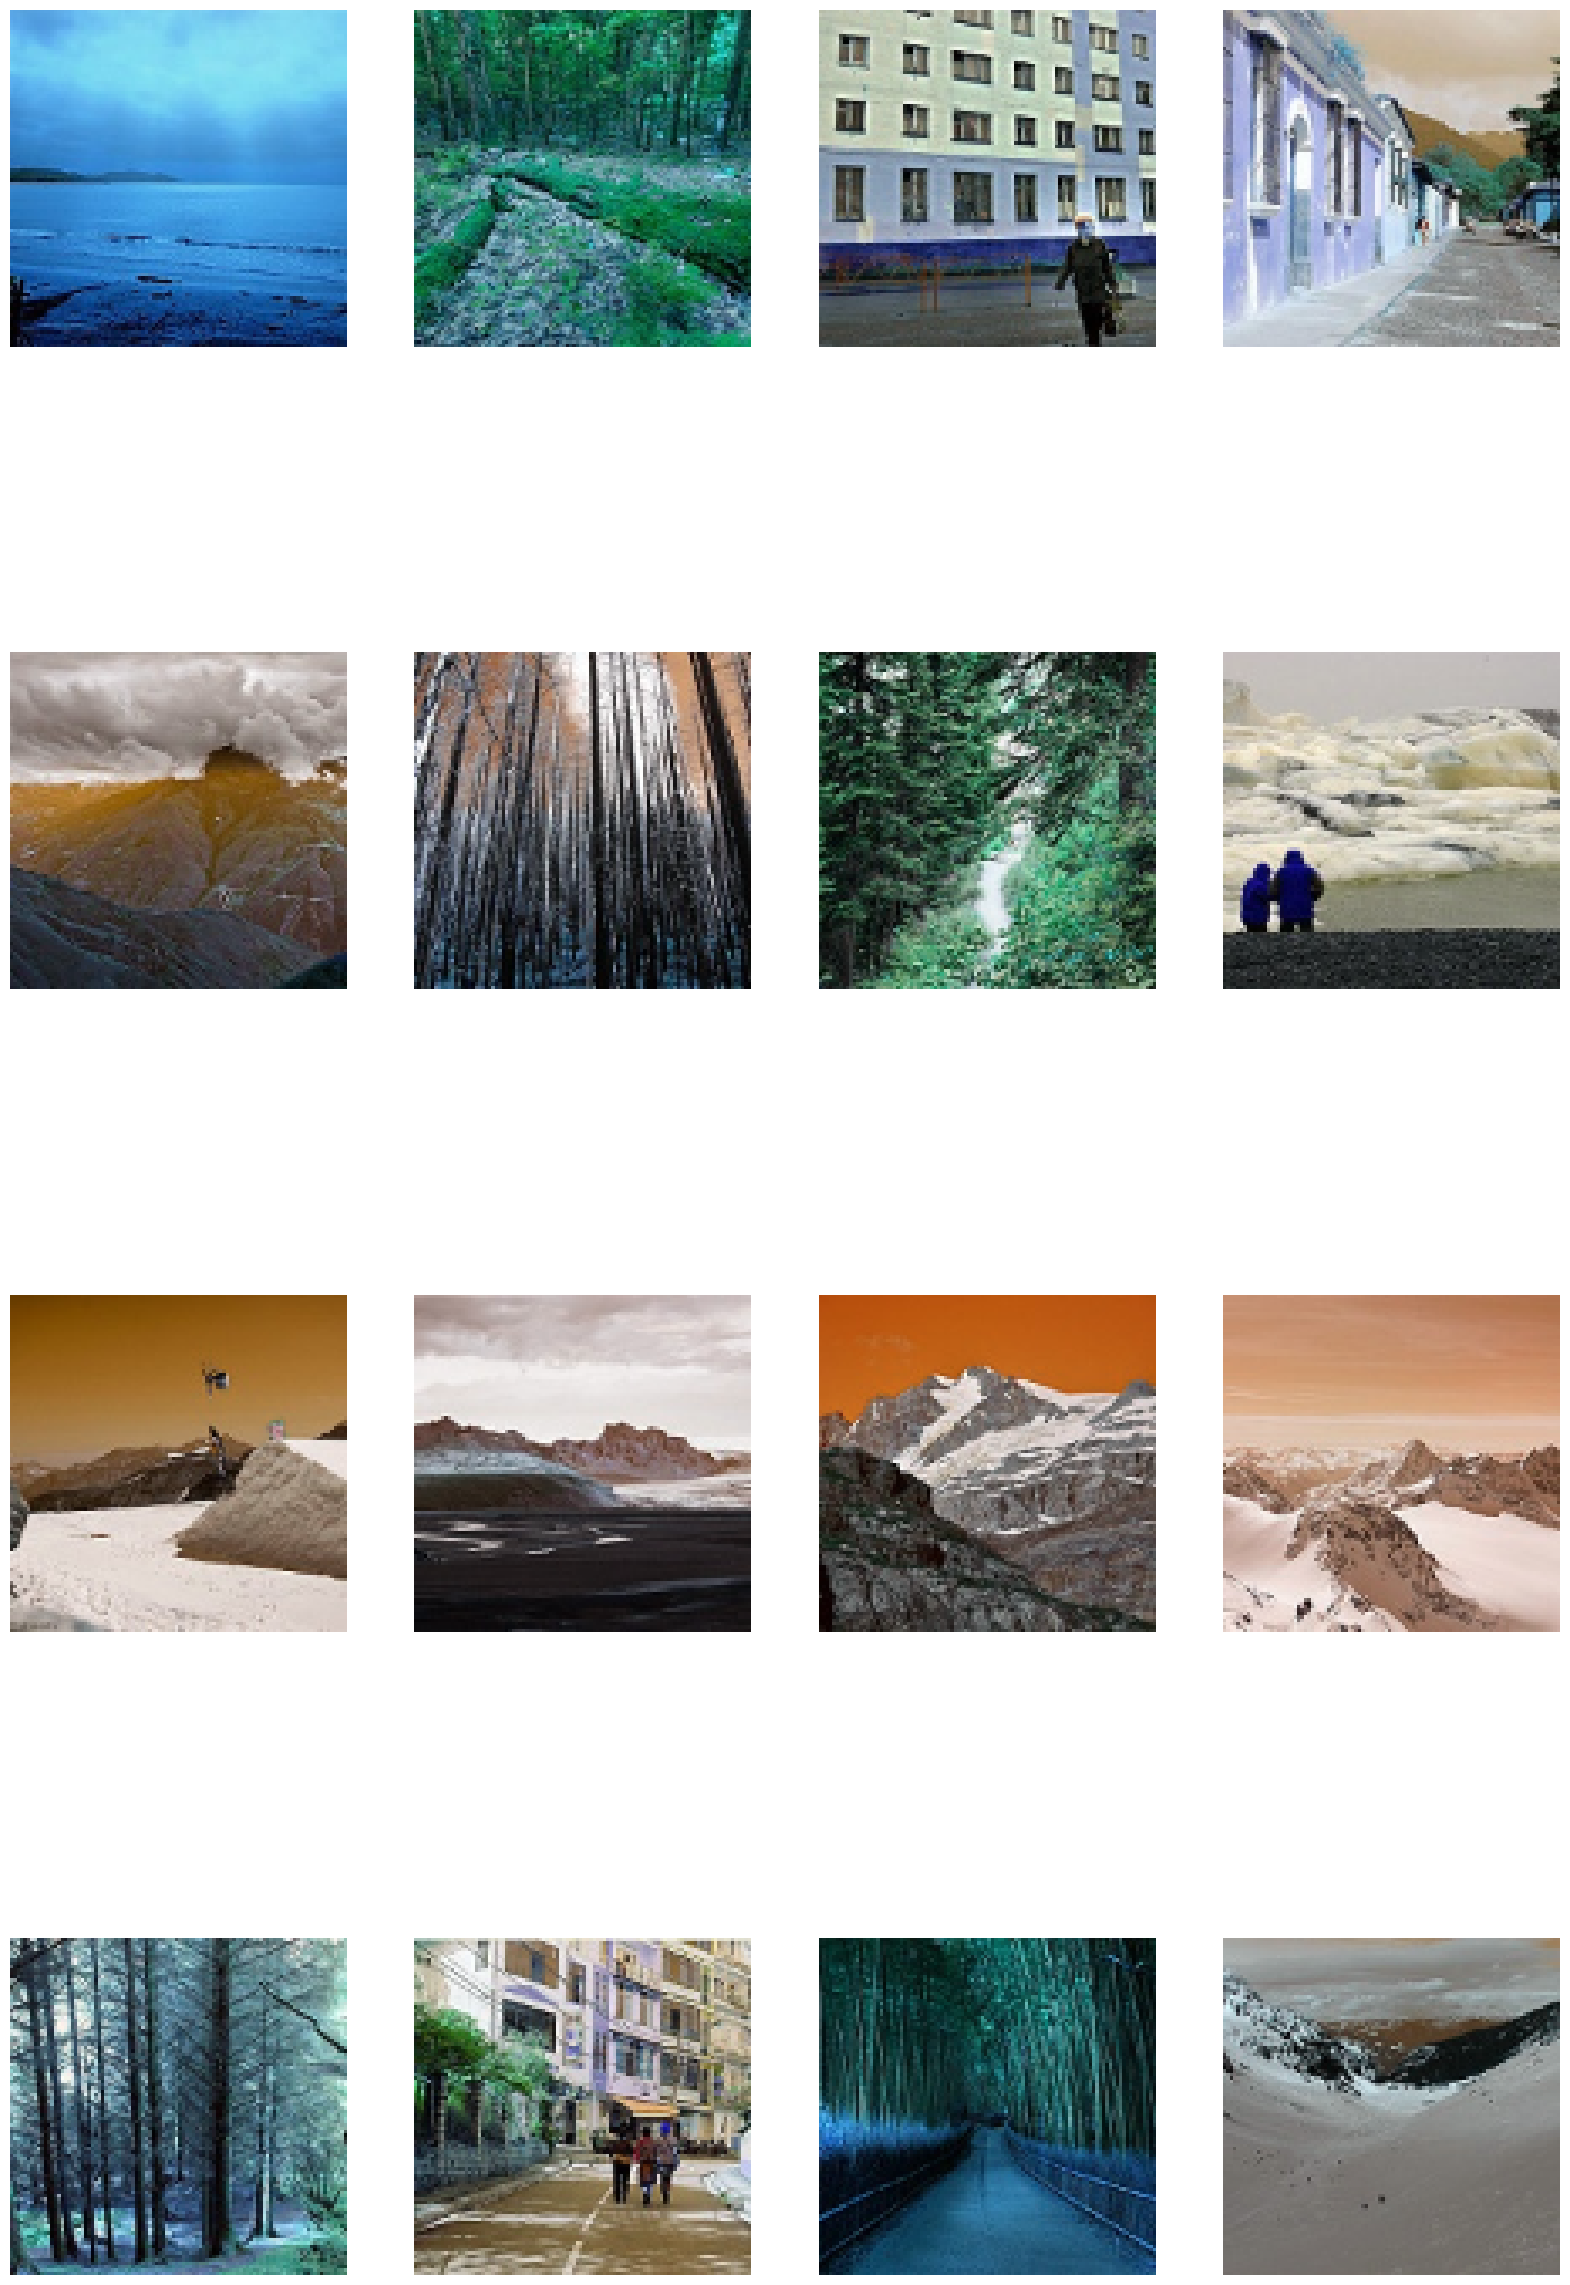

In [14]:
plot_some_image(X_pred, None, 'Prediction')

In [15]:
# Mỗi pixel là một node.

# Cạnh giữa các pixel được tạo bằng thuật toán Delaunay triangulation (nối các điểm lân cận thành tam giác).

# Delaunay là gì?
# Là một thuật toán tạo tam giác từ tập điểm.

# Giúp nối các pixel lại sao cho tam giác không bị méo → tự nhiên và đều.

# Trong ngữ cảnh này, giúp xác định ai kết nối với ai trong đồ thị từ ảnh.

# Mỗi ảnh → biến thành một đồ thị đặc trưng (graph) với:

# Node: pixel

# Feature: màu sắc pixel (RGB)

# Edge: kết nối theo tam giác (Delaunay)
def image_to_graph(image, new_size=(32, 32)):
    image = np.array(image)
    h, w, c = image.shape
    image = resize(image, new_size, anti_aliasing=True)
    pixels = image.reshape(-1, c)
    positions = np.column_stack(np.unravel_index(np.arange(new_size[0] * new_size[1]), (new_size[0], new_size[1])))
    tri = Delaunay(positions)
    edges = [(simplex[i], simplex[(i + 1) % 3]) for simplex in tri.simplices for i in range(3)]
    edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)
    x = torch.tensor(pixels, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def convert_dataset_to_graph(X, y=None):
    graphs = []
    for i, image in enumerate(X):
        graph = image_to_graph(image)
        if y is not None:
            graph.y = torch.tensor(y[i], dtype=torch.long)
        graphs.append(graph)
    return graphs

train_graphs = convert_dataset_to_graph(X_train, y_train)
test_graphs = convert_dataset_to_graph(X_test, y_test)

    # Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

In [16]:

class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dims[0])  # Lớp GCN đầu tiên: từ số đặc trưng đầu vào (vd: 3 - RGB) → 256 chiều
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])  # Lớp GCN thứ hai: 256 → 128 chiều
        self.batch_norm1 = BatchNorm(hidden_dims[1])  # Chuẩn hóa batch sau conv2 để ổn định huấn luyện
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.batch_norm2 = BatchNorm(hidden_dims[2])
        self.fc = Linear(hidden_dims[2], num_classes) # Lớp fully connected cuối cùng để phân loại.
        self.relu = ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch # Trích xuất đặc trưng x, chỉ số cạnh edge_index, và batch (để pooling)
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.batch_norm1(x)
        x = self.relu(self.conv3(x, edge_index))
        x = self.batch_norm2(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

input_dim = 3 # Số đặc trưng (feature) đầu vào của mỗi node. Ở đây là 3 (R, G, B).
hidden_dims = [256, 128, 64] # Danh sách các số node ẩn (256 → 128 → 64).
num_classes = len(code) # Số lớp cần phân loại (6 lớp cảnh khác nhau).

model = GCNModel(input_dim, hidden_dims, num_classes).to(device)


In [17]:
# CrossEntropyLoss thường dùng trong bài toán phân loại đa lớp, như bài của bạn (6 lớp cảnh khác nhau).
criterion = torch.nn.CrossEntropyLoss()
#  thuật toán tối ưu hóa, cụ thể là Adam — một phương pháp phổ biến để cập nhật trọng số mô hình trong quá trình huấn luyện.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# def train():
#     model.train()
#     total_loss = 0
#     for data in train_loader:
#         optimizer.zero_grad()
#         out = model(data)
#         loss = criterion(out, data.y)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(train_loader)

# def validate():
#     model.eval()
#     correct = 0
#     for data in test_loader:
#         out = model(data)
#         pred = out.argmax(dim=1)
#         correct += (pred == data.y).sum().item()
#     return correct / len(test_graphs)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    correct = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(test_graphs)

In [18]:
# def save_model(model, model_dir='model', filename='gcn_dt.pth'):
#     os.makedirs(model_dir, exist_ok=True)
#     save_path = os.path.join(model_dir, filename)
    
#     torch.save(model.state_dict(), save_path)
#     print(f"Model successfully saved to: {save_path}")

## ========================= Run on Kaggle =========================

def save_model(model, model_dir='/kaggle/working', filename='gcn_dt.pth'):
    os.makedirs(model_dir, exist_ok=True)
    save_path = os.path.join(model_dir, filename)
    
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model successfully saved to: {save_path}")

In [19]:
num_epochs = 400
patience = 30  # số epoch tối đa không cải thiện trước khi dừng
best_val_acc = 0.0
epochs_no_improve = 0
train_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss = train()
    val_acc = validate()

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch}, Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        save_model(model)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Stopping early at epoch {epoch} due to no improvement in validation accuracy for {patience} epochs.')
        break


Epoch 1, Loss: 1.3118, Validation Accuracy: 0.4623
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 2, Loss: 1.2450, Validation Accuracy: 0.4403
Epoch 3, Loss: 1.2279, Validation Accuracy: 0.5147
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 4, Loss: 1.2201, Validation Accuracy: 0.4703
Epoch 5, Loss: 1.2156, Validation Accuracy: 0.4927
Epoch 6, Loss: 1.2052, Validation Accuracy: 0.5237
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 7, Loss: 1.1918, Validation Accuracy: 0.5303
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 8, Loss: 1.1888, Validation Accuracy: 0.5297
Epoch 9, Loss: 1.1852, Validation Accuracy: 0.5203
Epoch 10, Loss: 1.1811, Validation Accuracy: 0.5293
Epoch 11, Loss: 1.1755, Validation Accuracy: 0.5373
✅ Model successfully saved to: /kaggle/working/gcn_dt.pth
Epoch 12, Loss: 1.1710, Validation Accuracy: 0.5243
Epoch 13, Loss: 1.1674, Validation Accuracy: 0.5410
✅ Model successfully saved to: /kaggle/work

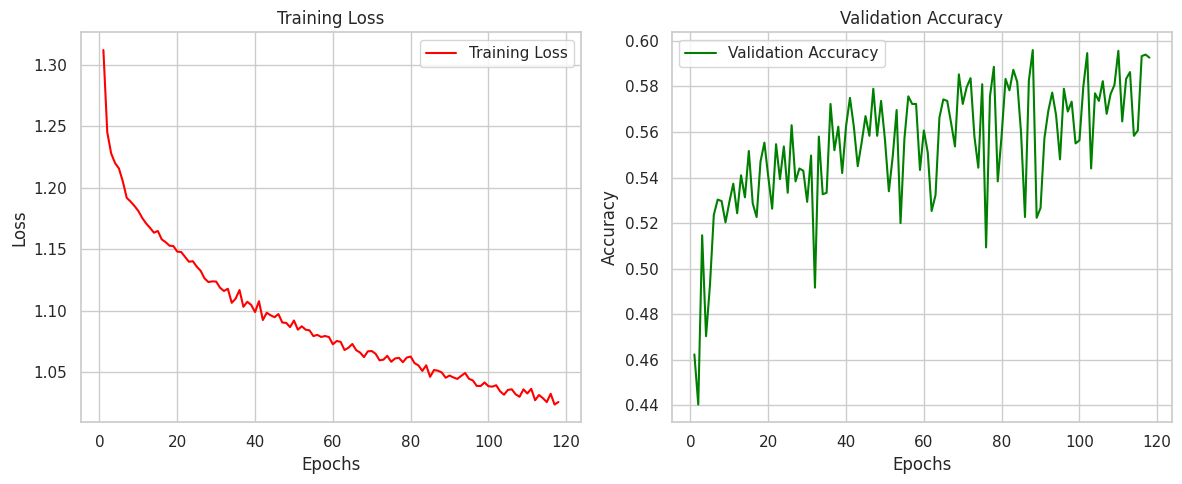

In [20]:
def plot_training_history(train_losses, val_accuracies):
    epochs = range(1, len(train_losses)+1)
    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    axs[0].plot(epochs, train_losses, label='Training Loss', color='red')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    axs[1].set_title('Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Sau khi train xong:
plot_training_history(train_losses, val_accuracies)


In [21]:
# def evaluate(model, test_loader, criterion):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for data in test_loader:
#             out = model(data)
#             loss = criterion(out, data.y)
#             total_loss += loss.item()
#             pred = out.argmax(dim=1)
#             correct += (pred == data.y).sum().item()
#             total += data.y.size(0)
#     avg_loss = total_loss / len(test_loader)
#     accuracy = correct / total

#     return avg_loss, accuracy

# Đánh giá
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total

    return avg_loss, accuracy


# Evaluate the model
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_accuracy))


Test Loss: 1.1855
Test Accuracy: 0.5927


In [22]:
model.eval()
all_outputs = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        all_outputs.append(out)
y_test_pred = torch.cat(all_outputs, dim=0)
print(f'Prediction Shape: {y_test_pred.shape}')

Prediction Shape: torch.Size([3000, 6])


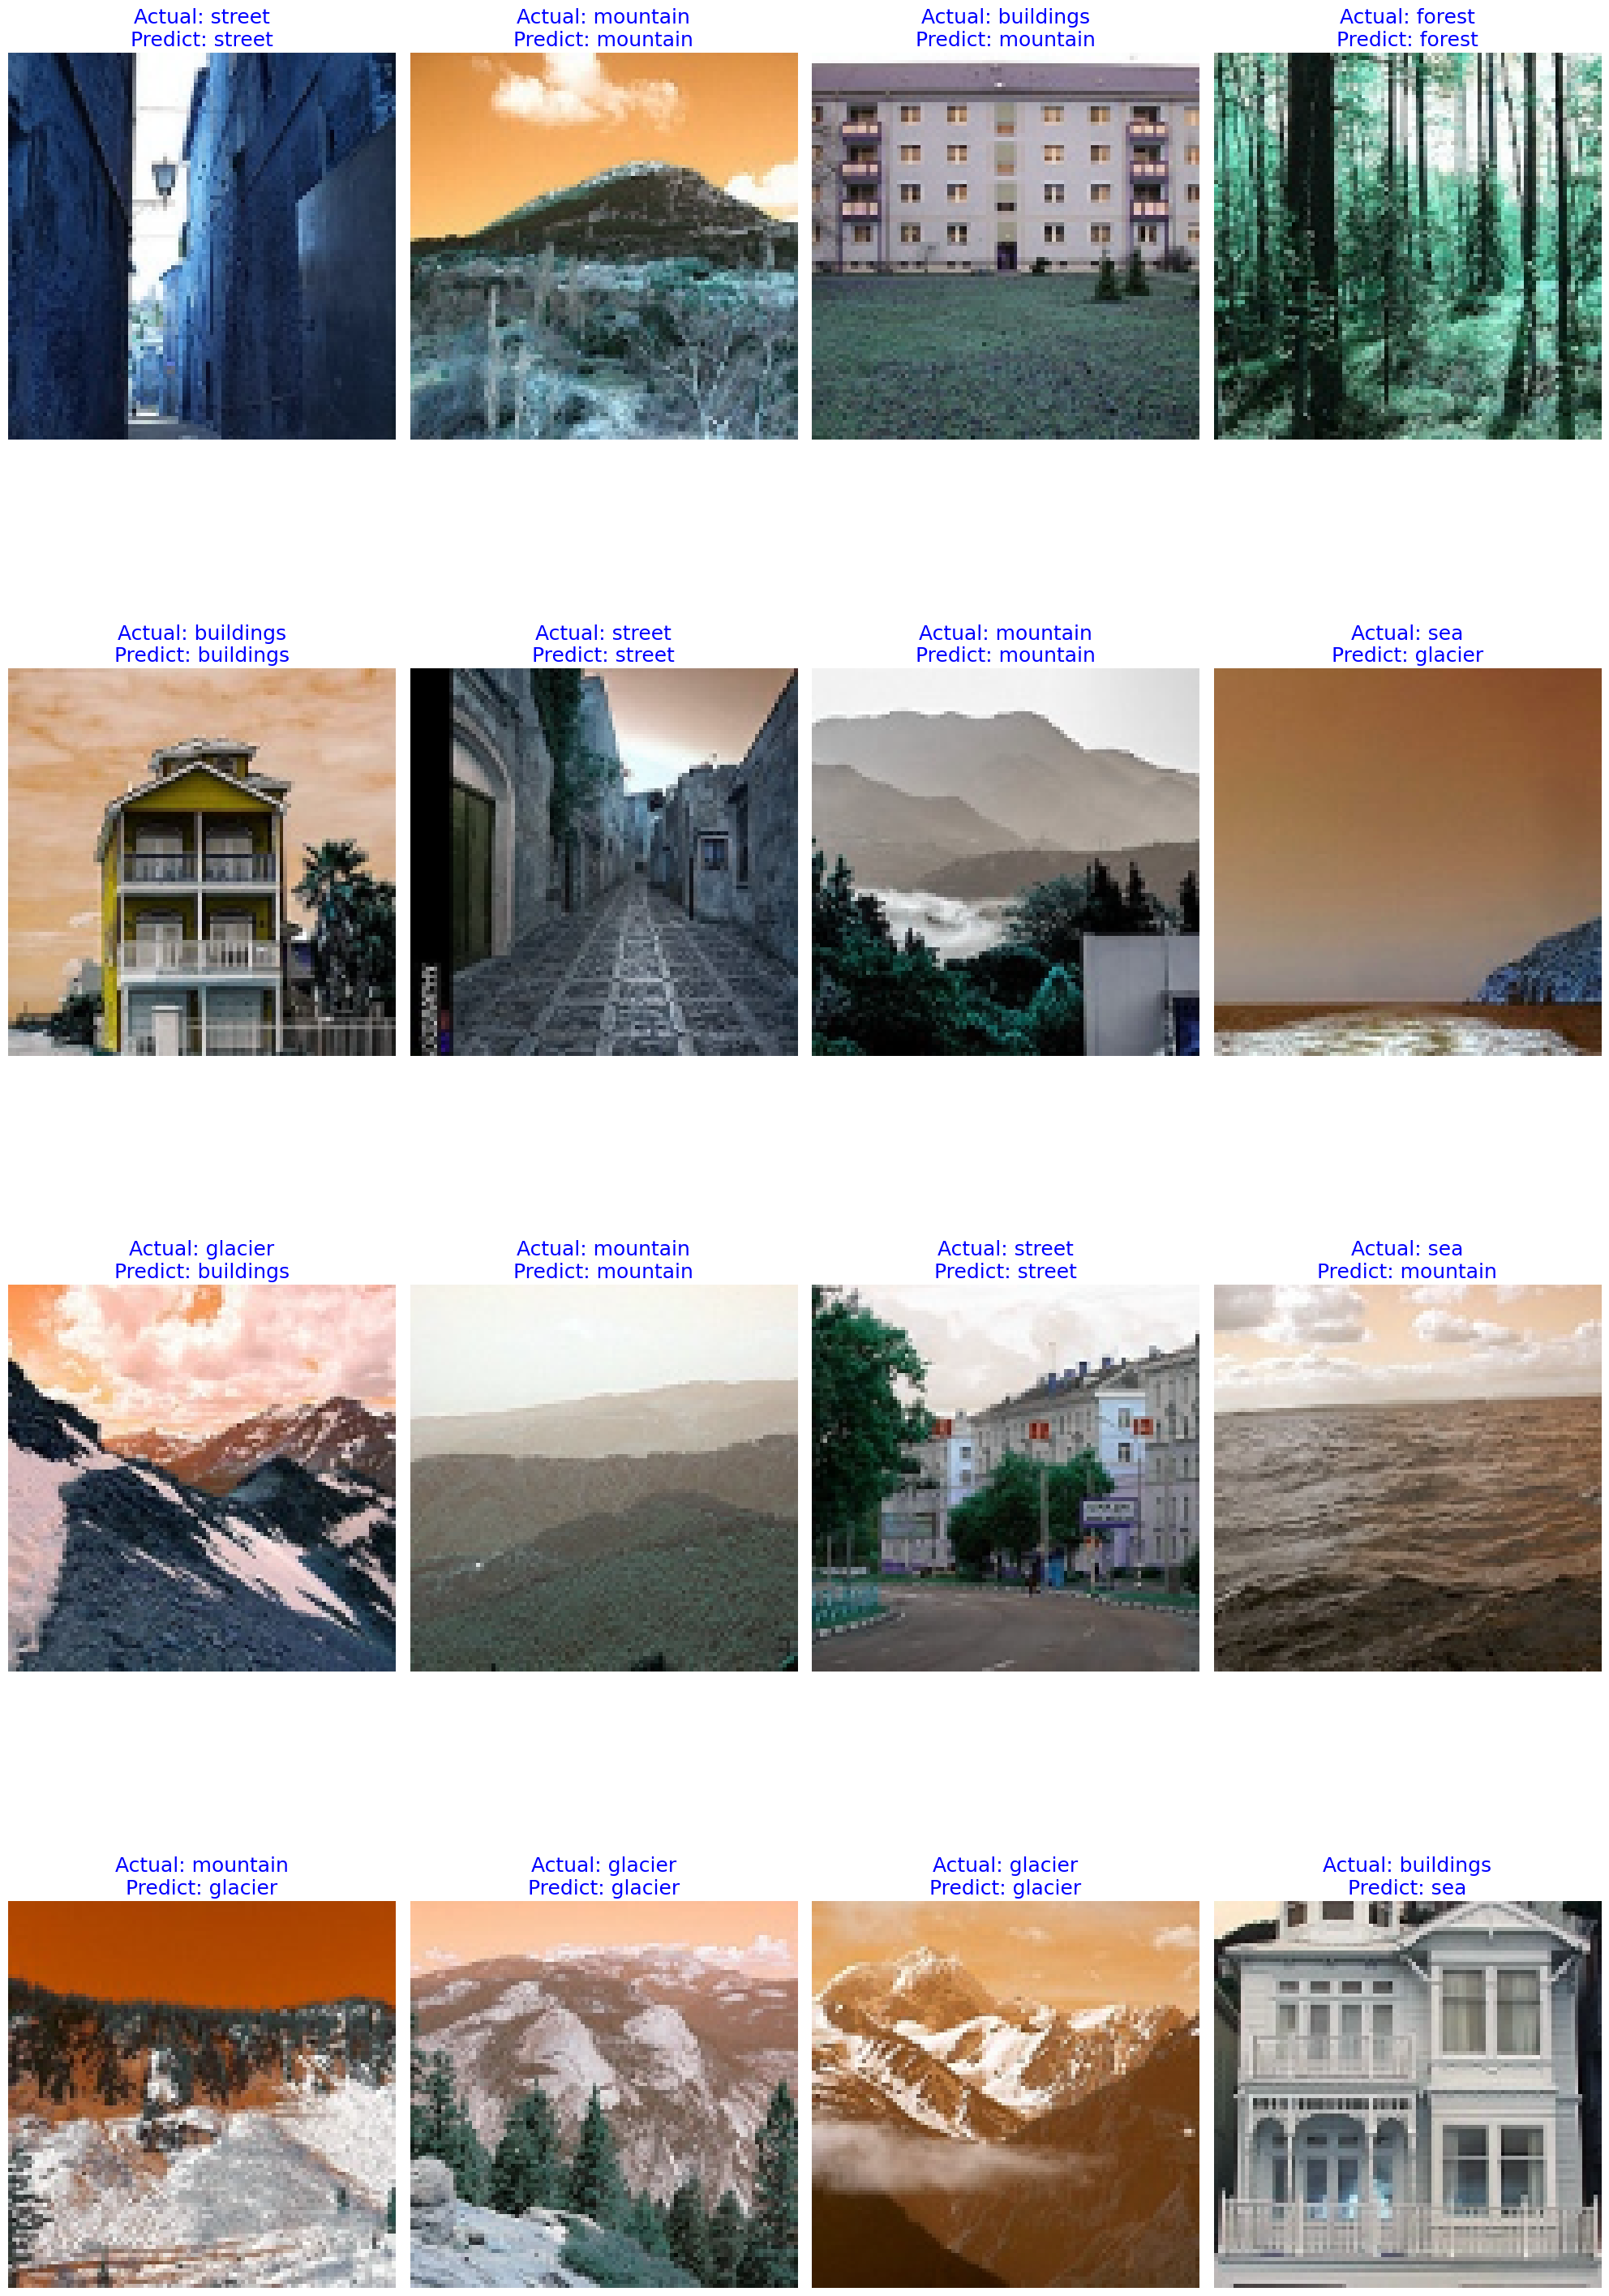

In [23]:
plt.figure(figsize=(20, 32))

selected_indices = list(np.random.randint(0, len(X_test), 16))

for n, i in enumerate(selected_indices):
    plt.subplot(4, 4, n + 1)

    img = np.array(X_test[i])
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.axis('off')

    actual_label = get_name(y_test[i])
    predicted_label = get_name(np.argmax(y_test_pred[i].cpu().numpy()))

    plt.title(f'Actual: {actual_label}\nPredict: {predicted_label}', fontdict={'fontsize': 18, 'color': 'blue'})

plt.tight_layout()
plt.show()


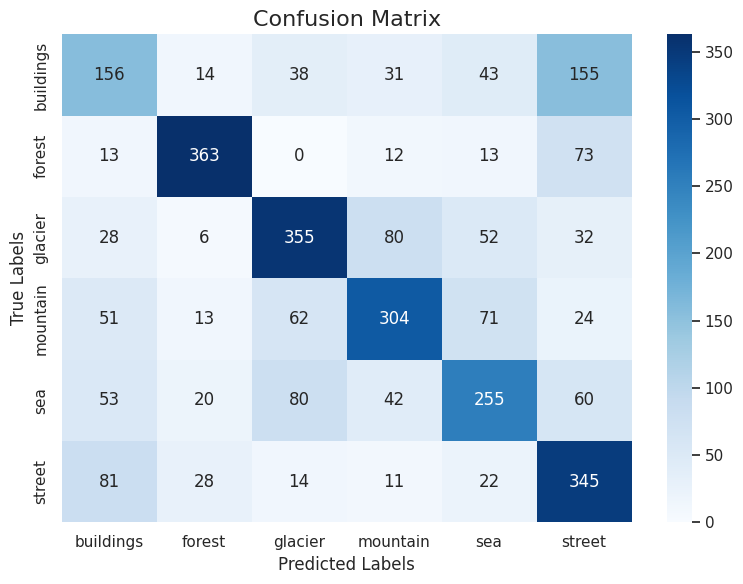

              precision    recall  f1-score      support
buildings      0.408377  0.356979  0.380952   437.000000
forest         0.817568  0.765823  0.790850   474.000000
glacier        0.646630  0.641953  0.644283   553.000000
mountain       0.633333  0.579048  0.604975   525.000000
sea            0.559211  0.500000  0.527950   510.000000
street         0.500726  0.688623  0.579832   501.000000
accuracy       0.592667  0.592667  0.592667     0.592667
macro avg      0.594307  0.588738  0.588140  3000.000000
weighted avg   0.597378  0.592667  0.591663  3000.000000


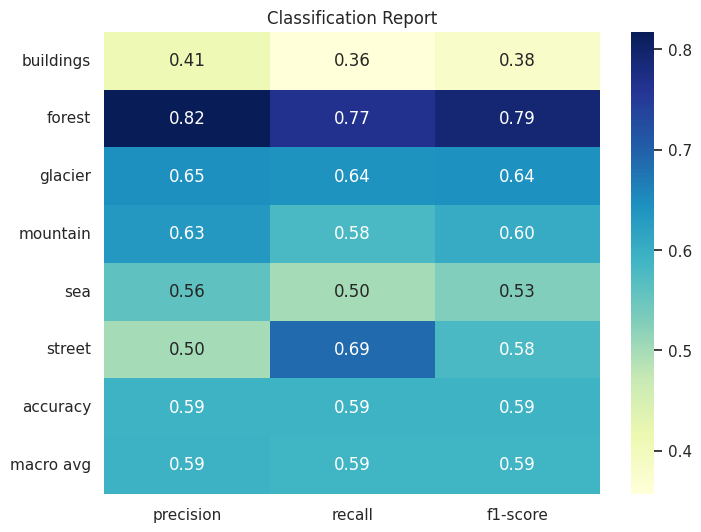

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_classification_report(true_labels, pred_labels, class_names):
    report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report")
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.tight_layout()
    plt.show()

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
pred_labels = np.argmax(y_test_pred.cpu().numpy(), axis=1)

plot_confusion_matrix(y_test, pred_labels, class_names)
plot_classification_report(y_test, pred_labels, class_names)

---

## ✅ **Lớp được mô hình phân loại tốt**

| **Lớp**      | **Số mẫu đúng** | **Nhận xét**                                                          |
| ------------ | --------------- | --------------------------------------------------------------------- |
| **forest**   | 363             | Phân loại rất chính xác, số lượng nhầm lẫn với các lớp khác rất thấp. |
| **glacier**  | 355             | Nhận diện tốt, chỉ có một số nhầm lẫn với `mountain` và `sea`.        |
| **street**   | 345             | Phân loại tốt, nhưng vẫn có một số nhầm với `buildings` và `forest`.  |
| **mountain** | 304             | Nhận diện tương đối tốt, tuy có nhầm với `glacier` và `sea`.          |

---

## ⚠️ **Lớp phân loại chưa tốt**

| **Lớp**       | **Số mẫu đúng** | **Nhận xét**                                                            |
| ------------- | --------------- | ----------------------------------------------------------------------- |
| **buildings** | 156             | Tỷ lệ nhầm cao với `street` (155) và các lớp khác như `glacier`, `sea`. |
| **sea**       | 255             | Nhầm khá nhiều với `glacier`, `buildings`, và `mountain`.               |

---

## 🔄 **Các nhầm lẫn đáng chú ý**

| **Từ lớp → Đến lớp**   | **Số lượng** | **Ghi chú**                                              |
| ---------------------- | ------------ | -------------------------------------------------------- |
| `buildings` → `street` | 155          | Rất đáng chú ý, mô hình nhầm nhiều giữa hai lớp này.     |
| `glacier` → `mountain` | 80           | Nhầm phổ biến, có thể do đặc trưng hình ảnh tương tự.    |
| `sea` → `glacier`      | 80           | Hai lớp này bị nhầm chéo khá nhiều.                      |
| `mountain` → `glacier` | 62           | Nhầm lẫn nhiều, phản ánh sự tương đồng giữa hai lớp này. |
| `sea` → `mountain`     | 42           | Dù không phải cao nhất nhưng vẫn cần chú ý cải thiện.    |

---

## 🧾 **Kết luận**

* Mô hình hoạt động **tốt với lớp `forest`, `glacier`, `street`, và `mountain`**.
* Cần **cải thiện khả năng phân biệt** các lớp có đặc trưng gần nhau như:

  * `buildings` ↔ `street`
  * `glacier` ↔ `mountain`, `sea`
  * `sea` ↔ `glacier`, `mountain`

In [25]:
def load_model(model, path='/kaggle/working/gcn_dt.pth'):
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    print(f"Model loaded from {path}")
    return model

loaded_model = GCNModel(input_dim=3, hidden_dims=[256, 128, 64], num_classes=6)
loaded_model = load_model(loaded_model)

Model loaded from /kaggle/working/gcn_dt.pth


In [26]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(image, graph_data, predicted_label):
    """
    Visualize the graph structure overlaid on the image
    """
    # Create a NetworkX graph from edge_index
    G = nx.Graph()
    
    # Get node positions (using pixel coordinates)
    h, w = image.shape[:2]
    pos = {i: (graph_data.x[i][1].item()*w, graph_data.x[i][0].item()*h) 
           for i in range(graph_data.x.shape[0])}
    
    # Add edges
    edge_index = graph_data.edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0,i], edge_index[1,i])
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    # Draw graph (with some transparency)
    nx.draw(G, pos, node_size=5, edge_color='yellow', 
            alpha=0.3, width=0.5, with_labels=False)
    
    plt.title(f'Predicted: {predicted_label}', fontsize=16)
    plt.axis('off')
    plt.show()


In [27]:
# Hàm xử lý ảnh từ URL
# def predict_from_url(url, model):
#     # Tải ảnh từ URL
#     response = requests.get(url)
#     img = Image.open(io.BytesIO(response.content))
    
#     # Tiền xử lý ảnh
#     img = img.convert('RGB')
#     img = np.array(img)
#     img = cv2.resize(img, (100, 100))  # Kích thước phù hợp với model
    
#     # Chuyển đổi thành đồ thị
#     graph = image_to_graph(img)
    
#     # Dự đoán
#     with torch.no_grad():
#         output = model(graph)
#         pred = output.argmax(dim=1).item()
    
#     # Hiển thị kết quả
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Predicted: {get_name(pred)}')
#     plt.show()
    
#     return get_name(pred)

# def predict_from_url(url, model):
#     response = requests.get(url)
#     img = Image.open(io.BytesIO(response.content))
#     img = img.convert('RGB')
#     img = np.array(img)
#     img = cv2.resize(img, (100, 100))
#     graph = image_to_graph(img)
#     graph = graph.to(device).cpu()

#     with torch.no_grad():
#         output = model(graph)
#         pred = output.argmax(dim=1).item()

#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Predicted: {get_name(pred)}')
#     plt.show()

#     return get_name(pred)

def predict_and_visualize_from_url(url, model, new_size=(32, 32)):
    # Download and process image
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    img = img.convert('RGB')
    img_np = np.array(img)
    img_resized = cv2.resize(img_np, (100, 100))  # Resize for prediction
    
    # Create graph from image
    graph = image_to_graph(img_resized, new_size)
    graph = graph.to(device)
    
    # Make prediction
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(graph)
        pred = output.argmax(dim=1).item()
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f'Original Image\nPredicted: {get_name(pred)}', fontsize=14)
    
    # Plot graph representation
    plt.subplot(1, 2, 2)
    
    # Create NetworkX graph
    G = nx.Graph()
    positions = graph.x.cpu().numpy()[:, :2]  # Use first two dimensions for position
    edge_index = graph.edge_index.cpu().numpy()
    
    # Add nodes with positions
    for i, pos in enumerate(positions):
        G.add_node(i, pos=(pos[0], pos[1]))
    
    # Add edges
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    
    # Get positions for drawing
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw graph
    nx.draw(G, pos, node_size=10, edge_color='gray', alpha=0.6, with_labels=False)
    plt.title('Graph Representation (Delaunay Triangulation)', fontsize=14)
    plt.axis('equal')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return get_name(pred)



In [28]:
urls = [
    "https://cdn.pixabay.com/photo/2017/03/28/21/44/autumn-2183489_640.jpg",
    "https://media.istockphoto.com/id/1360554439/vi/anh/%C4%91%E1%BA%A3o-nhi%E1%BB%87t-%C4%91%E1%BB%9Bi-maldives.jpg?s=612x612&w=0&k=20&c=pqWxvBFhn0_mJQF-oNyiDS56iahHule2vZmmVbjc_TA=",
    "https://vanphongchothue.vn/uploads/noidung/images/toa-thap-view-dep-nhat-thanh-pho-ho-chi-minh.jpg"
]

Predicting image from https://cdn.pixabay.com/photo/2017/03/28/21/44/autumn-2183489_640.jpg


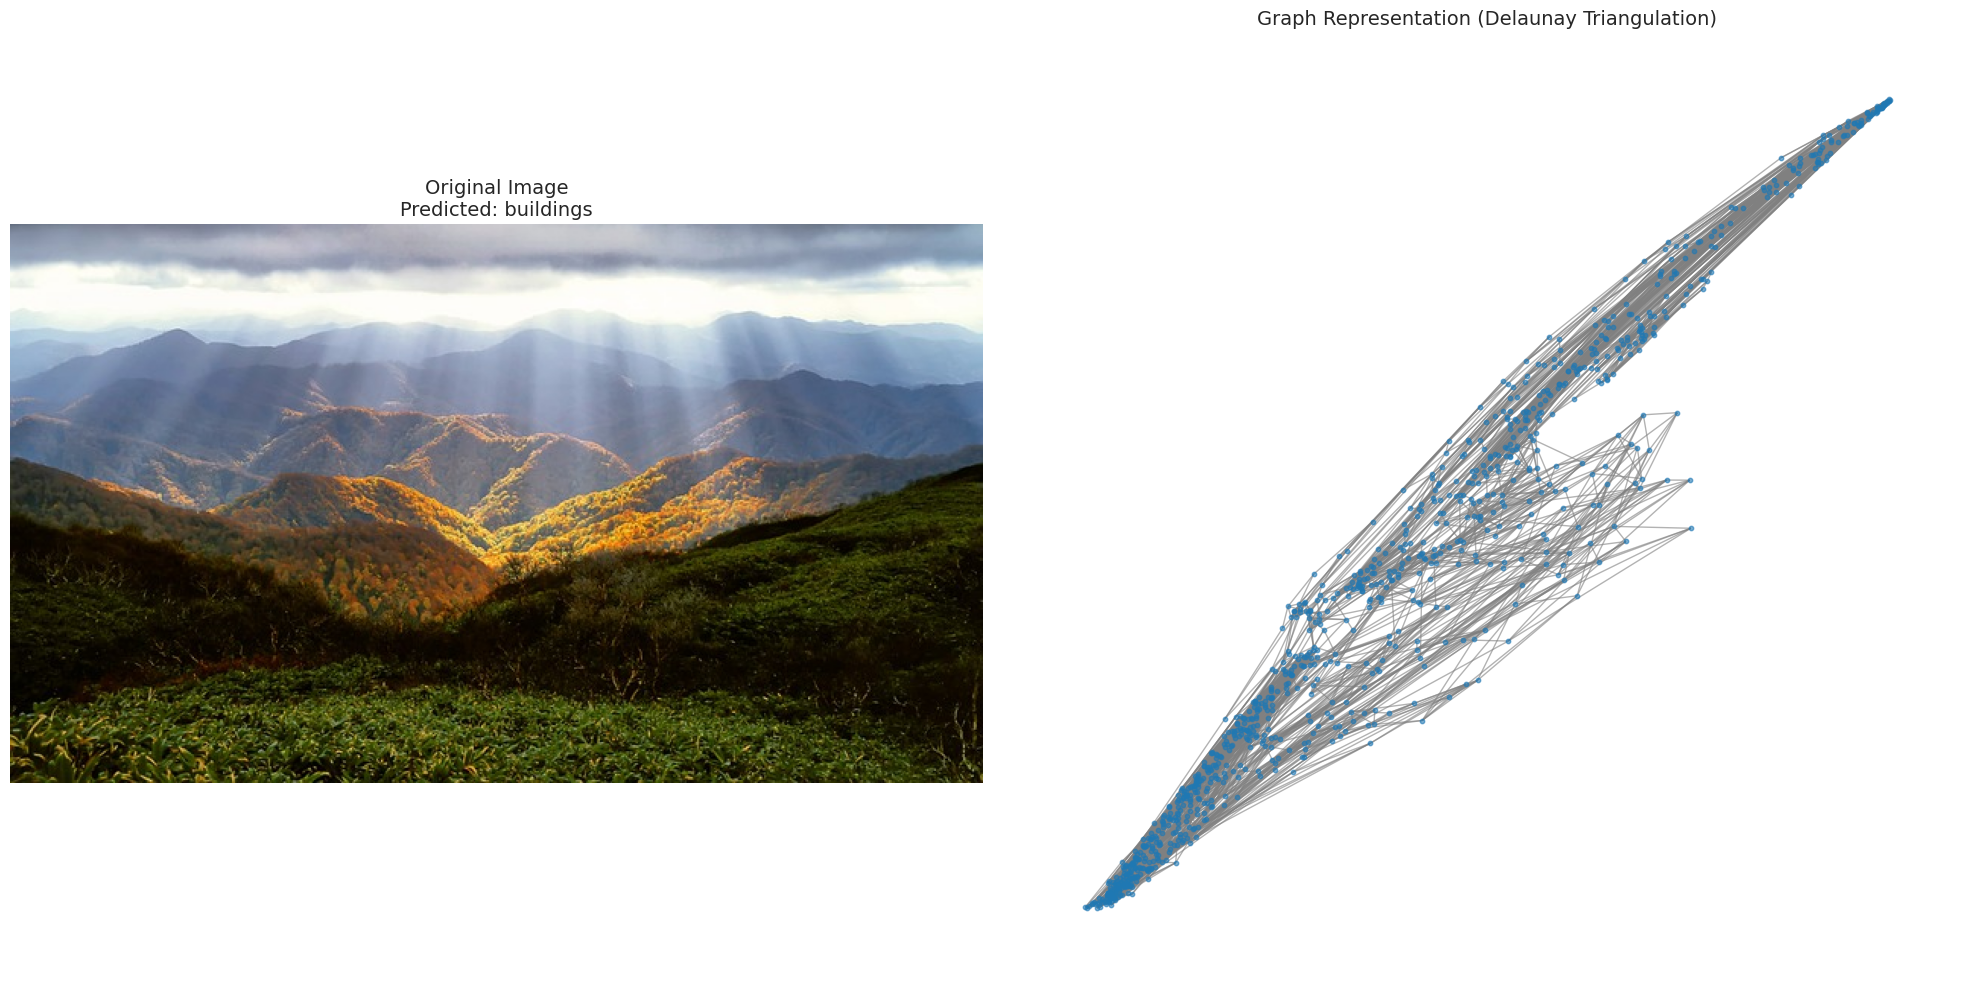

Prediction result: buildings

Predicting image from https://media.istockphoto.com/id/1360554439/vi/anh/%C4%91%E1%BA%A3o-nhi%E1%BB%87t-%C4%91%E1%BB%9Bi-maldives.jpg?s=612x612&w=0&k=20&c=pqWxvBFhn0_mJQF-oNyiDS56iahHule2vZmmVbjc_TA=


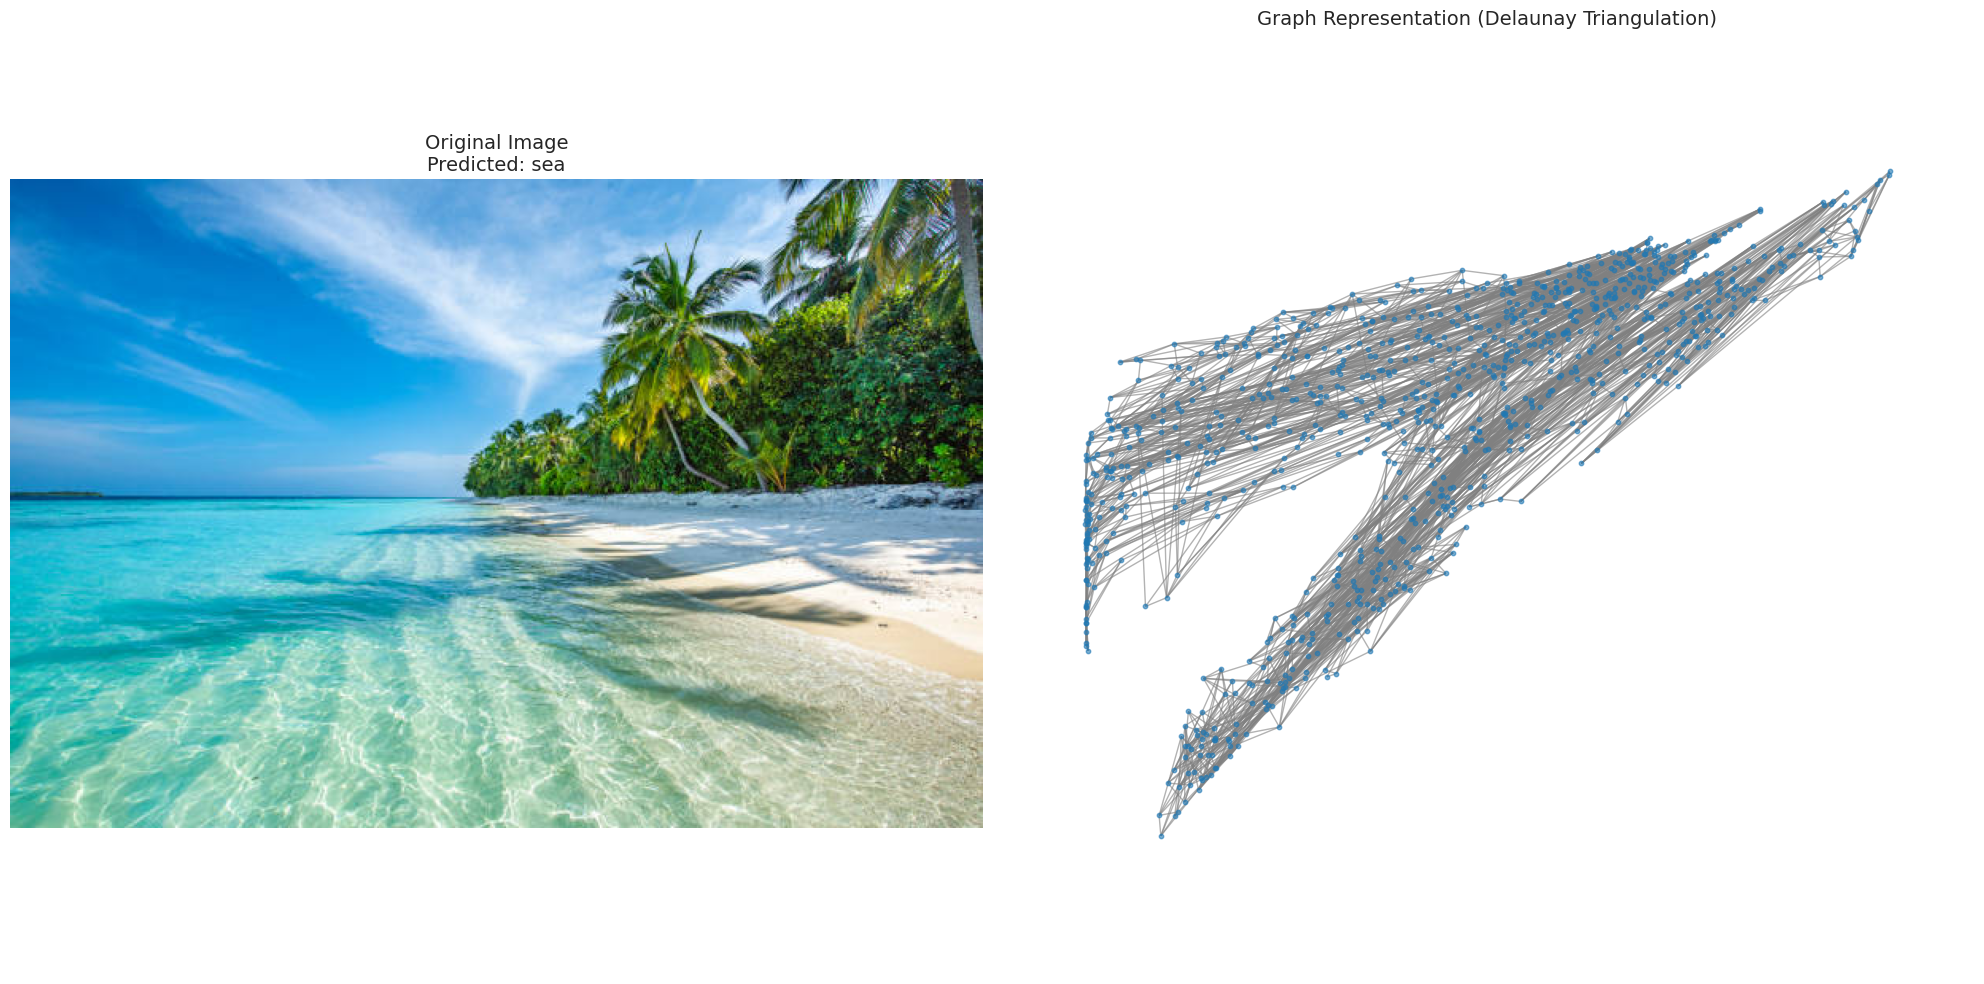

Prediction result: sea

Predicting image from https://vanphongchothue.vn/uploads/noidung/images/toa-thap-view-dep-nhat-thanh-pho-ho-chi-minh.jpg


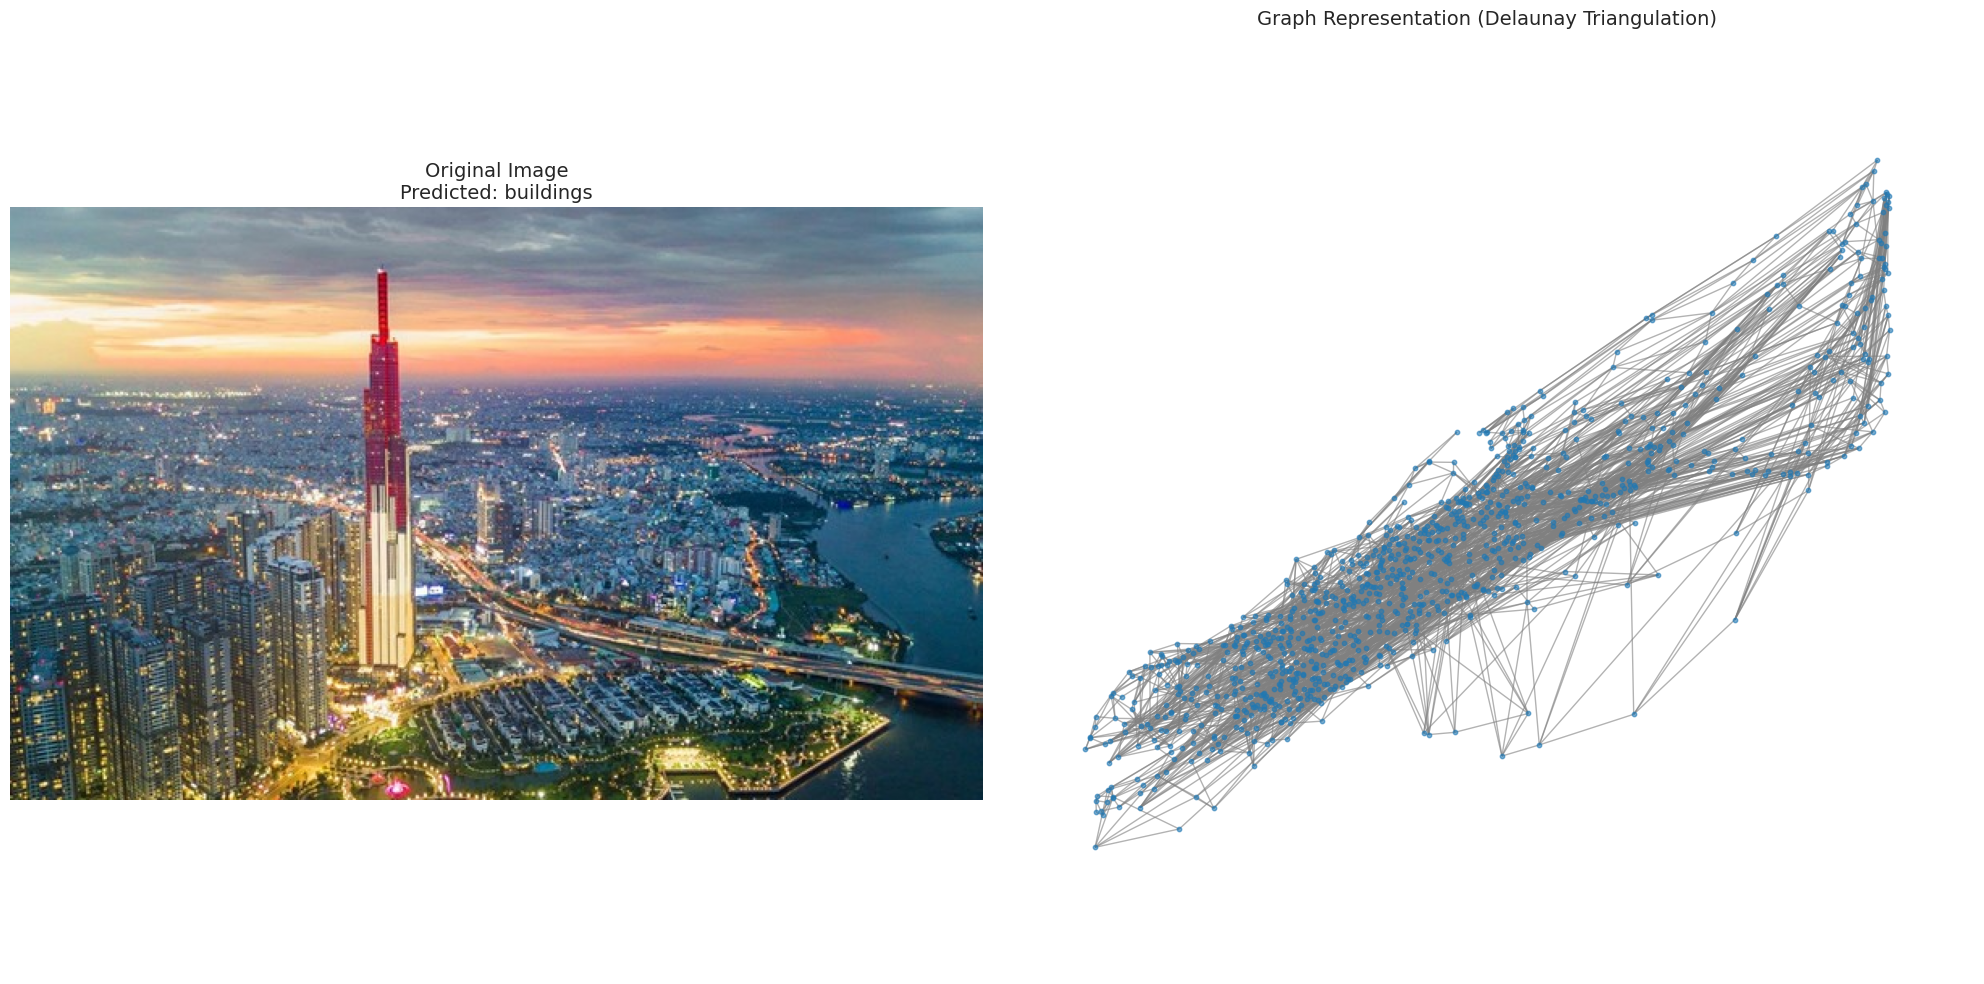

Prediction result: buildings



In [29]:
for url in urls:
    try:
        print(f"Predicting image from {url}")
        prediction = predict_and_visualize_from_url(url, loaded_model)
        print(f"Prediction result: {prediction}\n")
    except Exception as e:
        print(f"Error processing {url}: {str(e)}\n")